In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table

import sys
sys.path.insert(0, "../")

import velociraptor
from mpl_utils import mpl_style

%matplotlib inline
plt.style.use(mpl_style)

In [2]:
with open("../rv_completeness.pkl", "rb") as fp:
    rv_completeness = pickle.load(fp)

In [3]:
print(rv_completeness.keys())

dict_keys(['N_bins', 'semilogx', 'equidensity', 'completeness'])


In [4]:
label_names = [
    ("phot_rp_mean_mag", r"\textrm{apparent rp magnitude}", False),
    ("phot_rp_mean_flux", r"\textrm{apparent rp flux}", True),
    ("phot_bp_mean_flux", r"\textrm{apparent bp flux}", True),
    ("phot_bp_mean_mag", r"\textrm{apparent bp magnitude}", False),
    ("bp_rp", r"\textrm{bp - rp}", False),
    ("phot_bp_rp_excess_factor", r"\textrm{bp-rp excess factor}", False),
    ("teff_val", r"$T_{\rm eff}$", False),
]

label_ranges = [
    ("phot_rp_mean_flux", 1.5e5, None),
    ("bp_rp", 1.25, 2.50)
]



In [5]:
rv_completeness["completeness"]["ra"].keys()

dict_keys(['bins', 'x', 'y', 'yerr'])

In [6]:
def _get_histogram_steps(x_bins, y, y_err):

    xx = np.array(x_bins).repeat(2)[1:]
    xstep = np.repeat((x_bins[1:] - x_bins[:-1]), 2)
    xstep = np.concatenate(([xstep[0]], xstep, [xstep[-1]]))
    # Now: add one step at end of row.
    x_ = np.append(xx, xx.max() + xstep[-1]) - xstep/2.0

    y_ = np.array(y).repeat(2)
    
    x_mid = x_bins
    return (x_, y_, x_mid, y, y_err)



def plot_rv_completeness(label_name, latex_label_name, equidensity=True, semilogx=True,
                         ax=None, title=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    else:
        fig = ax.figure
    
    # Get the right index
    index = np.where((rv_completeness["equidensity"] == equidensity) \
                   * (rv_completeness["semilogx"] == semilogx))[0][0]
    
    N_bins = rv_completeness["N_bins"]
    data = rv_completeness["completeness"][label_name]
    
    bins = data["bins"][index]
    x, y, x_mid, y_mid, y_mid_err = _get_histogram_steps(data["x"][index], data["y"][index], data["yerr"][index])
    
    kwds = dict(linestyle="-", marker="None")
    kwds.update(kwargs)
    line, = ax.plot(x, y, **kwds)
    #ax.errorbar(x_mid, y_mid, yerr=y_mid_err, fmt=None, capsize=0, c=line.get_color())
    ax.set_xlabel(latex_label_name)
    ax.set_ylabel(r"\textrm{radial velocity completeness}")
    
    if title is None:
        title = r"\textrm{equi-density}" if equidensity else r"\textrm{equi-spaced}"
    
    ax.set_title(title)
    if semilogx:
        ax.semilogx()
    
    return fig
        

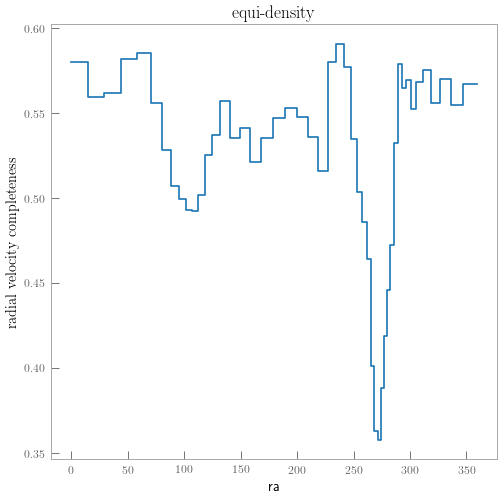

In [7]:
fig = plot_rv_completeness("ra", "ra", semilogx=False, equidensity=True)

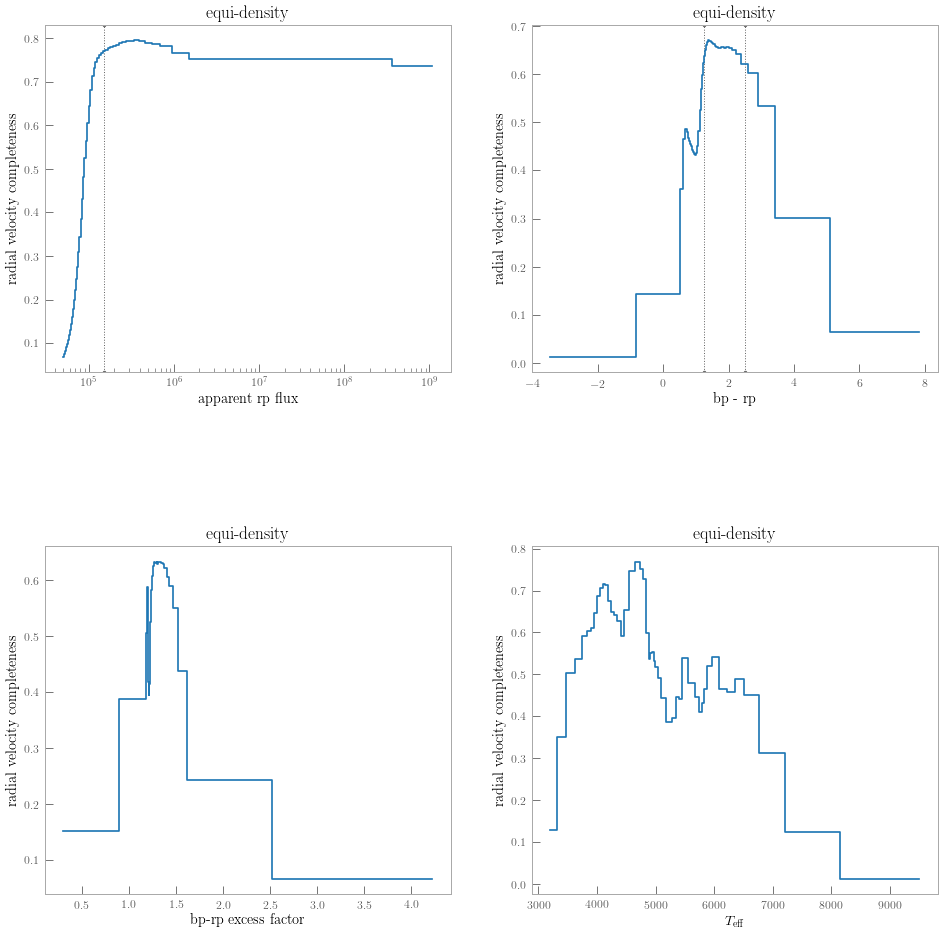

In [8]:
# Plot the radial velocity completeness against pertinent properties.
equidensity = True

label_names = [
    ("phot_rp_mean_flux", r"\textrm{apparent rp flux}", True, equidensity),
    ("bp_rp", r"\textrm{bp - rp}", False, equidensity),
    ("phot_bp_rp_excess_factor", r"\textrm{bp-rp excess factor}", False, equidensity),
    ("teff_val", r"$T_{\rm eff}$", False, equidensity),
]
K = len(label_names)
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for i, (label_name, latex_label_name, semilogx, equidensity) in enumerate(label_names):
    ax = axes.flatten()[i]
    
    _ = plot_rv_completeness(label_name, latex_label_name, 
                             semilogx=semilogx, equidensity=equidensity, ax=ax)
    
    for ln, lower_value, upper_value in label_ranges:
        if ln == label_name:
            if lower_value is not None:
                ax.axvline(lower_value, c="#666666", linestyle=":", linewidth=1, zorder=-1)
            if upper_value is not None:
                ax.axvline(upper_value, c="#666666", linestyle=":", linewidth=1, zorder=-1)
            break
                
            
    

In [9]:

# Load the data and generate a validity mask for SB2
from astropy.io import fits
data = fits.open("../data/rv-all.fits")[1].data
in_sb2_range = np.ones(len(data), dtype=bool)

for label_name, lower_value, upper_value in label_ranges:
    if upper_value is not None:
        in_sb2_range *= (upper_value >= data[label_name])

    if lower_value is not None:
        in_sb2_range *= (data[label_name] >= lower_value)

    print(label_name, lower_value, upper_value)
        
print("Total sources in valid SB2 range: {}".format(sum(in_sb2_range)))

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':


phot_rp_mean_flux 150000.0 None


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


bp_rp 1.25 2.5
Total sources in valid SB2 range: 1975816


In [10]:
# TODO: Re-calculate the RV completeness as a function of the parameters?
print(np.min(data["phot_rp_mean_mag"][in_sb2_range]))
print(np.max(data["phot_rp_mean_mag"][in_sb2_range]))


1.8629
11.8217


In [11]:
# ADQL Query:
"""
select * from gaiadr2.gaia_source
where radial_velocity is null
and astrometric_excess_noise > 0
and bp_rp >= 1.25
and bp_rp <= 2.50
and phot_rp_mean_flux >= 1.5e5
"""
# saved to data/smbh-binaries.fits

'\nselect * from gaiadr2.gaia_source\nwhere radial_velocity is null\nand astrometric_excess_noise > 0\nand bp_rp >= 1.25\nand bp_rp <= 2.50\nand phot_rp_mean_flux >= 1.5e5\n'

In [12]:
from astropy.table import Table
smbhb = Table.read("../data/smbh-binaries.fits")


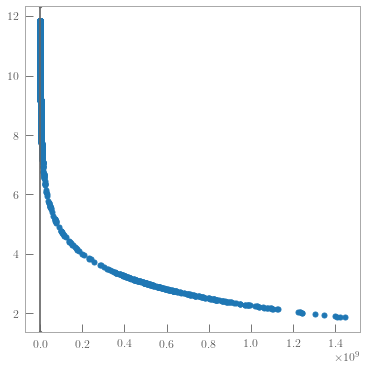

In [13]:
fig, ax = plt.subplots()
#ax.hist(smbhb["phot_rp_mean_flux"])
ax.scatter(smbhb["phot_rp_mean_flux"], smbhb["phot_rp_mean_mag"])
ax.axvline(1.5e5, c="#666666")

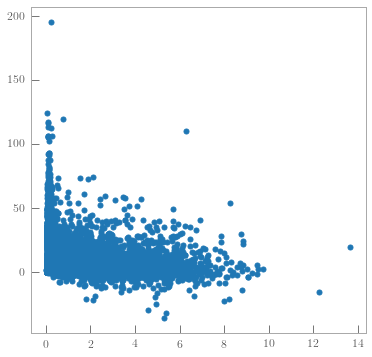

In [14]:
fig, ax = plt.subplots()
ax.scatter(smbhb["astrometric_excess_noise"], smbhb["parallax"])

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(12.398934768730896, -15.536429311612245)

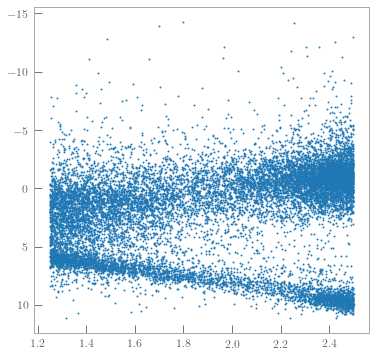

In [15]:
smbhb["absolute_g_mag"] = smbhb["phot_g_mean_mag"] \
                        + 5 * np.log10(smbhb["parallax"]/100.0)

fig, ax = plt.subplots()
ax.scatter(smbhb["bp_rp"], smbhb["absolute_g_mag"], s=1, alpha=0.9)
ax.set_ylim(ax.get_ylim()[::-1])

In [16]:
print(smbhb.dtype.names)
#fig, ax = plt.subplots()
#ax.scatter(smbhb["apparent_g_mag"], smbhb[""])

('solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

[]

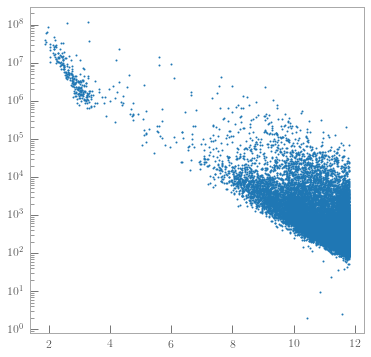

In [17]:
fig, ax = plt.subplots()
ax.scatter(smbhb["phot_rp_mean_mag"], smbhb["phot_rp_mean_flux_error"], s=1)
ax.semilogy()

0.013239857198934255
19.979711677639315


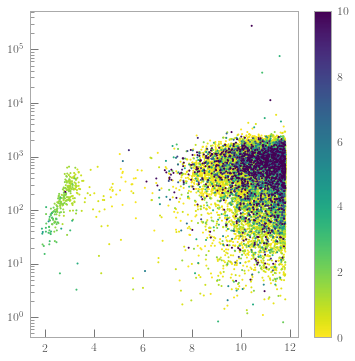

In [18]:
idx = np.argsort(smbhb["astrometric_excess_noise"])

fig, ax = plt.subplots()
scat = ax.scatter(smbhb["phot_rp_mean_mag"][idx], (smbhb["phot_rp_mean_flux_over_error"])[idx],
                  c=smbhb["astrometric_excess_noise"][idx], s=1, vmin=0, vmax=10,
                  cmap="viridis_r")
ax.semilogy()
print(np.min(smbhb["astrometric_excess_noise"]))
print(np.max(smbhb["astrometric_excess_noise"]))
plt.colorbar(scat)

[]

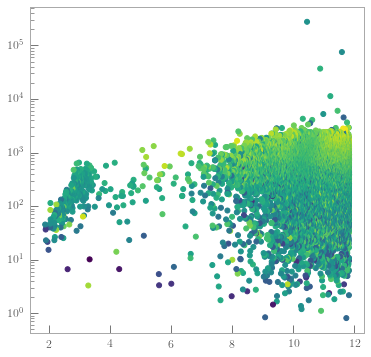

In [19]:

# calculate amplitude
# from https://watermark.silverchair.com/stw3357.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAagwggGkBgkqhkiG9w0BBwagggGVMIIBkQIBADCCAYoGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMdPYpqLVBhckzML48AgEQgIIBW28L6CNXEU7rs_Z6CtQYQxVmNfDUVut9omzHtxI8gmL1-eFfkRzv9Pw2LyKn0UQjD0hT8LYP2BeqYMzHllBdZY6dfWINopQ0lKpowTorYb6Y-TMCbbhlYkTVr_HKHfahC7_STEsmA3oMqw7nIb3AVMIKWf_kHq5rkiyrYUyqvwC7qJp1-D3dVxNAIXElOH1VJ846mevNio_kh_JitiOm-AiXzv9JEIYwfk9eKoLkqKzr0bkFc9Aj9GKBXD_w0rdP9y7yY2GVIglNnV7rF2kC2GOVuwST6qpKS7mzVt95G00mWYrf47e5TiTUKzZF1ty5i6io9RJS8douj--B5hAPNQcheOMCN40ljeE-M6w6JmU0fOMA58tDNPyDMUzJh4EICyawdhNwjO5t1fQo188XJxmCW2QG9JgJGRR3qP8rrgD_2WWqeldYMh1sWhx5cSGMMlf_VDKgO5q9ll1j
# np.log10(np.sqrt(num_ccd_crossings) * phot_g_mean_flux_error/phot_g_mean_flux)

amp = np.log10(np.sqrt(smbhb["astrometric_n_good_obs_al"]) \
             * smbhb["phot_g_mean_flux"]/smbhb["phot_g_mean_flux_error"])

fig, ax = plt.subplots()
ax.scatter(smbhb["phot_rp_mean_mag"], smbhb["phot_rp_mean_flux"]/smbhb["phot_rp_mean_flux_error"],
           c=amp)
ax.semilogy()

1.4838706657432204
5.370915149223415


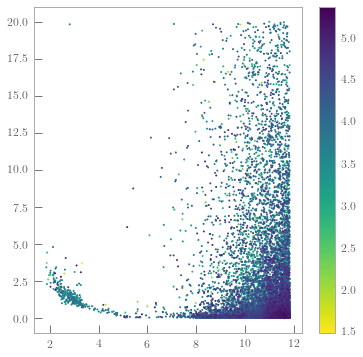

In [20]:
idx = np.argsort(amp)

fig, ax = plt.subplots()
scat = ax.scatter(smbhb["phot_rp_mean_mag"][idx], smbhb["astrometric_excess_noise"][idx],
                  c=amp[idx], s=1,
                  cmap="viridis_r")
#ax.semilogy()
print(np.min(amp))
print(np.max(amp))
plt.colorbar(scat)


(10, -5)

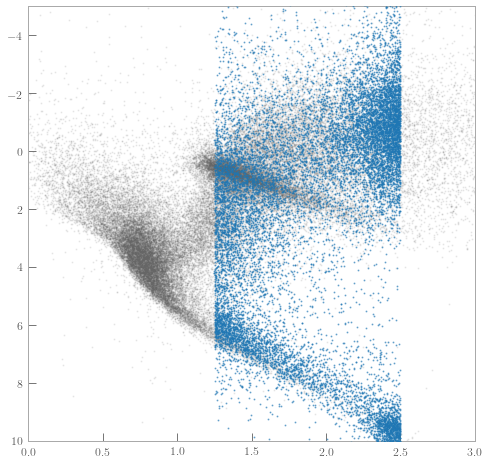

In [21]:
fig, ax =  plt.subplots(figsize=(8, 8))
idx = np.random.choice(len(data), 50000)
#print(idx)
ax.scatter(data["bp_rp"][idx], data["absolute_g_mag"][idx], s=1, alpha=0.1, c="#666666")
ax.scatter(smbhb["bp_rp"], smbhb["absolute_g_mag"], s=1, alpha=0.5, zorder=10)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(0, 3)
ax.set_ylim(10, -5)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


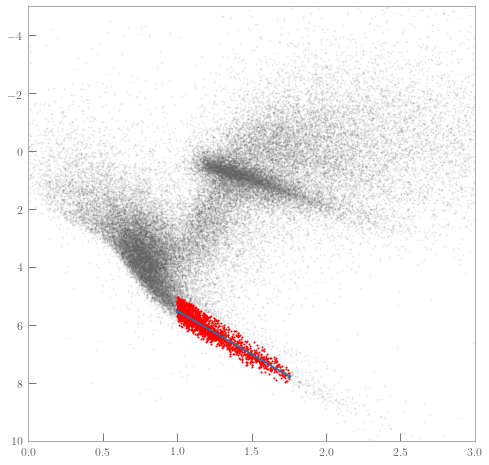

In [22]:
#  Select things directly along the main-sequence
fig, ax =  plt.subplots(figsize=(8, 8))
idx = np.random.choice(len(data), 50000)
#print(idx)
mask = np.zeros(len(data), dtype=bool)
mask[idx] = True
ax.scatter(data["bp_rp"][idx], data["absolute_g_mag"][idx], s=1, alpha=0.1, c="#666666")
#ax.scatter(smbhb["bp_rp"], smbhb["absolute_g_mag"], s=1, alpha=0.5, zorder=10)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(0, 3)
ax.set_ylim(10, -5)

xi = np.array([1, 1.75])
yi = 3 * xi + 2.5
ax.plot(xi, yi)

within_range = (np.abs((3 * data["bp_rp"] + 2.5) - data["absolute_g_mag"]) < 0.5) \
             * (data["bp_rp"] < 1.75) * (data["bp_rp"] > 1)
ax.scatter(data["bp_rp"][mask * within_range], data["absolute_g_mag"][mask * within_range],
           c="r", s=1)

import scipy.optimize as op
line = lambda x, *p: np.polyval(p, x)
p_opt, p_cov = op.curve_fit(line, data["bp_rp"][within_range], data["absolute_g_mag"][within_range],
            p0=[3, 2.5])


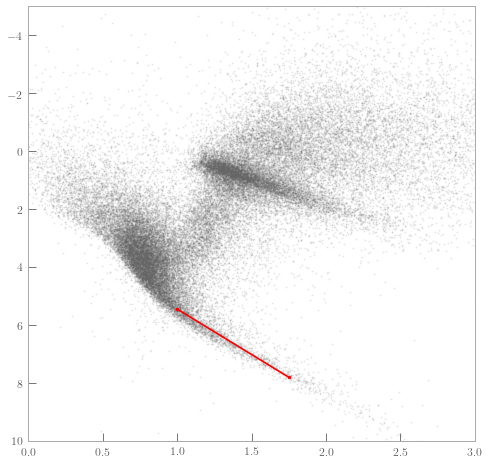

In [23]:
#  Select things directly along the main-sequence
fig, ax =  plt.subplots(figsize=(8, 8))
idx = np.random.choice(len(data), 50000)
#print(idx)
mask = np.zeros(len(data), dtype=bool)
mask[idx] = True
ax.scatter(data["bp_rp"][idx], data["absolute_g_mag"][idx], s=1, alpha=0.1, c="#666666")
#ax.scatter(smbhb["bp_rp"], smbhb["absolute_g_mag"], s=1, alpha=0.5, zorder=10)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(0, 3)
ax.set_ylim(10, -5)

xi = np.array([1, 1.75])
ax.plot(xi, line(xi, *p_opt), c='r')


--


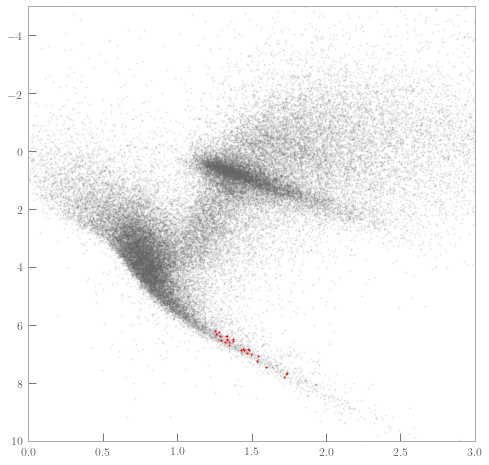

In [24]:
candidates = (np.abs(smbhb["absolute_g_mag"] - line(smbhb["bp_rp"], *p_opt)) < 0.15) \
           * (smbhb["bp_rp"] >= 1) * (smbhb["bp_rp"] <= 1.75) \
           * (smbhb["astrometric_excess_noise"] > 3)
#  Select things directly along the main-sequence
fig, ax =  plt.subplots(figsize=(8, 8))
idx = np.random.choice(len(data), 50000)
#print(idx)
mask = np.zeros(len(data), dtype=bool)
mask[idx] = True
ax.scatter(data["bp_rp"][idx], data["absolute_g_mag"][idx], s=1, alpha=0.1, c="#666666")
#ax.scatter(smbhb["bp_rp"], smbhb["absolute_g_mag"], s=1, alpha=0.5, zorder=10)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(0, 3)
ax.set_ylim(10, -5)

print(sum(candidates))
ax.scatter(smbhb["bp_rp"][candidates], smbhb["absolute_g_mag"][candidates],
           c="r", s=1)

In [25]:
smbhb[candidates]

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,absolute_g_mag
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,solRad,solRad,solRad,solLum,solLum,solLum,,,
int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,str13,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,str77,str99,float64
1635721458409799680,Gaia DR2 321230052996162560,321230052996162560,238237121,2015.5,17.807188877735015,0.5994549839243303,35.85410353626677,0.6845255713993916,8.26016132404926,0.6686768507089068,12.352994,147.5714002874559,1.3294056481493195,-39.779911879189584,1.5673676707585467,0.14095615,0.19550574,-0.2829757,-0.027738156,0.070538,-0.044674445,-0.26651907,0.099128075,0.11809914,0.15293863,121,121,100,21,171.77756,76554.42,3.0917734214299233,3429.1792281013395,31,False,0.09642176,1.410830381536091,0.28122979884991933,0.09670917,14,9,0.7929448,0,14,False,122,191007.38027593592,125.54919068714214,1521.3749,12.485741,13,71940.48451940963,126.03940499675473,570.7777,13.208955,13,173155.56923845175,272.42491329798435,635.6084,11.665829,1.2831758,0,1.5431261,0.72321415,0.81991196,nan,nan,0,nan,nan,nan,NOT_AVAILABLE,127.42548116797518,-26.844910339440844,30.821170215624765,26.027027473778737,100001,4348.6665,4224.04,4486.69,nan,nan,nan,nan,nan,nan,200111,0.6859433,0.6443893,0.7270167,0.15159874,0.13793187,0.1652656,http://geadata.esac.esa.int/data-server/datalink/links?ID=321230052996162560,,7.070683308307882
1635721458409799680,Gaia DR2 2224477538148043776,2224477538148043776,906128898,2015.5,331.517152541267,1.

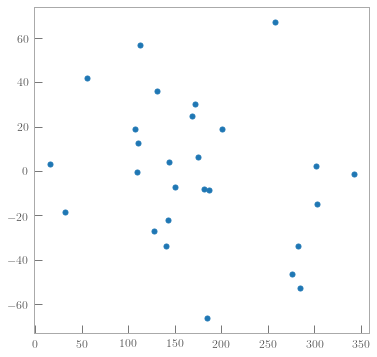

In [26]:
fig, ax = plt.subplots()
ax.scatter(smbhb["l"][candidates], smbhb["b"][candidates])